In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

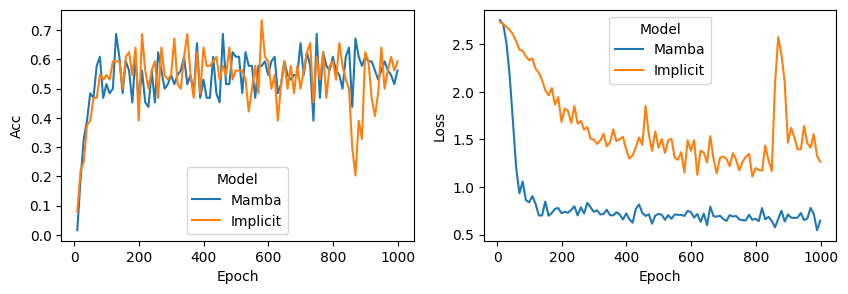

In [6]:
model_type = "boomerang"
task = 1
max_iters = 2000
thr = False
logdir = os.path.join("tmp", f"task{task}-{max_iters}-{model_type}-{thr}")
df_mamba = pd.read_pickle(logdir)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True)
sns.lineplot(df_mamba, x="Epoch", y="Acc", hue="Model", ax=ax[0])
sns.lineplot(df_mamba, x="Epoch", y="Loss", hue="Model", ax=ax[1])
plt.show()

In [10]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
from train import Boomerang, Implicit, ReasoningDataset, SequenceClassifier


@eqx.filter_jit
def compute_accuracy(model, inputs, targets, masks):
    def forward_single(inp, tgt, msk):
        logits = model(inp)
        preds = jnp.argmax(logits, axis=-1)
        correct = (preds == tgt) * msk
        return correct.sum(), msk.sum()

    correct, total = jax.vmap(forward_single)(inputs, targets, masks)
    return correct.sum() / (total.sum() + 1e-8)


@eqx.filter_jit
def compute_accuracy_seq(model, inputs, targets, masks):
    def forward_single(inp, tgt, msk):
        logits = model.sequential(inp)
        preds = jnp.argmax(logits, axis=-1)
        correct = (preds == tgt) * msk
        return correct.sum(), msk.sum()

    correct, total = jax.vmap(forward_single)(inputs, targets, masks)
    return correct.sum() / (total.sum() + 1e-8)


key = jrandom.key(0)
keys = jrandom.split(key, 2)

dataset = ReasoningDataset()

implicit_model = SequenceClassifier(
    vocab_size=dataset.VOCAB_SIZE,
    d_model=ReasoningDataset.NUM_OUTPUT,
    d_state=16,
    d_inner=128,
    model_class=Implicit if model_type == "implicit" else Boomerang,
    max_iters=max_iters,
    # with_thr=thr,
    key=keys[0],
)

implicit_model = eqx.tree_deserialise_leaves(f"{logdir}.eqx", implicit_model)

eval_inputs, eval_targets, eval_masks = dataset.generate_batch(
    keys[1], 1000, "simple" if task == 1 else "complex"
)

print(10 * "-", " Running in parallel mode ", 10 * "-")
acc = compute_accuracy(implicit_model, eval_inputs, eval_targets, eval_masks)
print("Accuracy: ", acc)

print(10 * "-", " Running in sequential mode ", 10 * "-")
acc = compute_accuracy_seq(implicit_model, eval_inputs, eval_targets, eval_masks)
print("Accuracy: ", acc)

----------  Running in parallel mode  ----------
Accuracy:  0.899
----------  Running in sequential mode  ----------
Accuracy:  0.9
